Imports

In [1]:
#imports

import torch
import matplotlib.pyplot as plt
import numpy as np
import time, os, pickle
import pandas as pd


import init
import loader
import visualisation
import parameters
import sys
from serial import RNN
from b_vae import B_VAE
from autoencoders import vae
sys.path.append('../../libs/')
import shjnn

Configure key details and init model

In [ ]:
# Initalize Model

#must be unique.
model_name = 'b_vae_test3'
epoch_select = None


# Load the model
saves_folder = "saves"
model_subfolder = None

if os.path.exists(saves_folder):
    for subfolder in os.listdir(saves_folder):
        subfolder_path = os.path.join(saves_folder, subfolder)
        if os.path.isdir(subfolder_path) and model_name in subfolder:
            model_subfolder = os.path.join(subfolder_path, "model")
            break

# Check for Pickle and PTH files
pickle_file = None
pth_files = []
for file in os.listdir(model_subfolder):
    if file.endswith(".pkl"):
        pickle_file = os.path.join(model_subfolder, file)
        print(f"(1/4) Found Config file: {pickle_file}")
        
    elif file.endswith(".pth"):
        pth_file = os.path.join(model_subfolder, file)
        print(f"(2/4) Found Model Save: {pth_file}")
        pth_files.append(pth_file)
if not pickle_file or not pth_files:
    print(f"Pickle file or PTH file not found in '{model_subfolder}'.")
    raise FileNotFoundError(f"Pickle file or PTH file not found in '{model_subfolder}'.")


# Load the model configuration
loaded = None
with open(pickle_file, 'rb') as f:
    try:
        loaded = pickle.load(f)
    except EOFError:
        pass
assert len(loaded) == 17


parameters.dataset = loaded[0]
parameters.dataset_PV = loaded[1]
parameters.trainer = loaded[2]
parameters.model = loaded[3]
parameters.rnn = loaded[4]
parameters.b_vae = loaded[5]
parameters.load_check = loaded[6]
parameters.model_params = loaded[7]
parameters.vae_params = loaded[8]
parameters.records = loaded[9]
parameters.device = loaded[10]
parameters.amp = loaded[11]
parameters.freq = loaded[12]
parameters.adaptive_training = loaded[13]
parameters.save = loaded[14]
parameters.split = loaded[15]
parameters.gridsearch = loaded[16]

assert parameters.load_check == True
print(f"(3/4) Loaded Config")

#load the model.
model_params = parameters.model_params
dev = torch.device(parameters.device)
if epoch_select is None:
    path = pth_files[-1]  # Use the last file in the list
else:
    path = [f for f in pth_files if f"{epoch_select}" in f]
    if not path:
        raise FileNotFoundError(f"No PTH file found for epoch {epoch_select}.")
    path = path[0]
assert model_params['func'] is not None
try:
    import torch.serialization
    torch.serialization.add_safe_globals(['numpy._core.multiarray.scalar'])
except (ImportError, AttributeError):
    pass
shjnn.load_state(path, model_params['func'], model_params['rec'], decoder = model_params['dec'], optimizer = model_params['optim'], loss = model_params['loss'], epochs = model_params['epochs'], dev = dev)
print(f"(4/4) Loaded Model from {path}")

print("---Success--- Model and parameters loaded successfully.")

Pickle file or PTH file not found in 'None'.


FileNotFoundError: Pickle file or PTH file not found in 'None'.

Function to get sweeps through the dataset along a specific axis.

In [3]:
def get_sweep_index(reference_index, sweep):
    """Get the sweep index based on the reference index and sweep type.
    Args:
        reference_index (int): The reference index to base the sweep on.
        sweep (str): The sweep type ('intensity', 'voltage', or 'delay').
    Returns:
        list: A list of indices corresponding to the sweep.
    """
    assert reference_index < len(parameters.dataset['y']), f"Reference index {reference_index} is out of bounds for dataset length {len(parameters.dataset['y'])}."
    INTENSITY = 0
    VOLTAGE = 1
    DELAY = 2
    output_list = []
    
    reference_metadata = parameters.dataset['y'][reference_index]
    if sweep == 'intensity':
        out_list = [i for i, meta in enumerate(parameters.dataset['y']) if meta[VOLTAGE] == reference_metadata[VOLTAGE] and meta[DELAY] == reference_metadata[DELAY]]
        output_list = sorted(out_list, key=lambda i: parameters.dataset['y'][i][INTENSITY])
    elif sweep == 'voltage' or sweep == 'bias':
        out_list = [i for i, meta in enumerate(parameters.dataset['y']) if meta[INTENSITY] == reference_metadata[INTENSITY] and meta[DELAY] == reference_metadata[DELAY]]
        output_list = sorted(out_list, key=lambda i: parameters.dataset['y'][i][VOLTAGE])
    elif sweep == 'delay':
        out_list = [i for i, meta in enumerate(parameters.dataset['y']) if meta[INTENSITY] == reference_metadata[INTENSITY] and meta[VOLTAGE] == reference_metadata[VOLTAGE]]
        output_list = sorted(out_list, key=lambda i: parameters.dataset['y'][i][DELAY])
    else:
        raise ValueError("Invalid sweep type. Choose 'intensity', 'voltage', or 'delay'.")
    return output_list

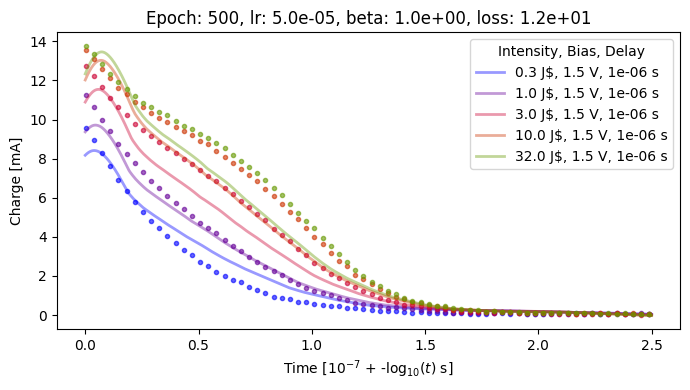

In [12]:
# Run model inference and visualisation

# select models to plot ('intensity', 'voltage', or 'delay')
plot_models = get_sweep_index(122, 'intensity')  # Example: sweep based on intensity from the first index

parameters.model_params['plot'] = plot_models
visualisation.display_random_fit(parameters.model_params, parameters.dataset, show=True, save=False, random_samples=False)


Sweep latent dimensions

In [7]:
for dim_idx in range(model_params['latent_dim']):
    print(f"---Visualising Latent Dimension {dim_idx}---")
    visualisation.sweep_latent_adaptive(parameters.model_params, parameters.dataset, dim_idx, save=False, show=True)


---Visualising Latent Dimension 0---


KeyboardInterrupt: 

In [4]:
# Test the time evolved sweep function
dim_idx = 0  # Example latent dimension
timesteps_of_interest = [1000]  # Example timesteps to analyze (0 - 999)

print(f"---Visualising Time-Evolved Latent Dimension {dim_idx}---")
visualisation.time_evolved_sweep(
    parameters.model_params, 
    parameters.dataset, 
    dim_idx, 
    timesteps_of_interest, 
    save=False, 
    show=True
)

---Visualising Time-Evolved Latent Dimension 0---


KeyboardInterrupt: 

Latent vectors shape: (150, 16) All timesteps shape: (150, 1000, 16)


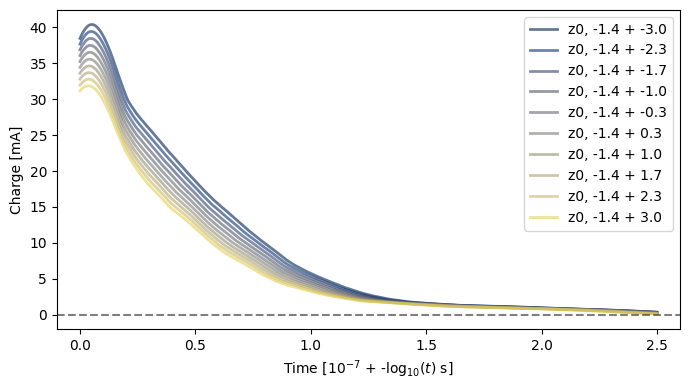

In [19]:
visualisation.sweep_latent_adaptive(parameters.model_params, parameters.dataset, 0, save=False, show=True)


UMAP Encoding of the latent space.


In [3]:
def get_latent_vectors(model_params, dataset, traj_idx=None):
    # Extract data from dataset
    trajectories = dataset['trajs']
    time_points = dataset['times']
    metadata = dataset['y']

    # Extract model components
    model_func = model_params['func']
    encoder = model_params['rec']
    decoder = model_params['dec']
    optimizer = model_params['optim']
    device = model_params['device']
    epoch_num = model_params['epochs']
    latent_dims = model_params['latent_dim']

    # Create inference function for trajectory encoding
    infer_step_encode = shjnn.make_infer_step(
        model_func, encoder, decoder, optimizer, device, 
        input_mode='traj', sample=False
    )

    # Get indices of all trajectories
    if traj_idx is None:
        sample_indices = list(range(len(trajectories)))
    else:
        sample_indices = traj_idx
        
    # Arrays to store latent vectors
    latent_vectors = []      # First timestep only
    all_latent_vectors = []  # All timesteps
    
    # Process each trajectory to collect latent representations
    for idx in sample_indices:
        # Prepare trajectory tensor
        traj_tensor = trajectories[idx].view(1, *trajectories[idx].size()).to(device)
        
        # Create time points tensor
        pred_times = np.linspace(0, 2.5, 1000)
        time_tensor = torch.Tensor(pred_times).to(device)

        # Get model prediction and latent vectors
        pred_x, pred_z = infer_step_encode(traj_tensor, time_tensor)
        
        # Store latent vectors
        latent_vectors.append(pred_z[0, 0, ...].detach().cpu().numpy())  # First timestep only
        all_latent_vectors.append(pred_z[0, ...].detach().cpu().numpy())  # All timesteps
        
    # Convert lists to numpy arrays
    latent_vectors = np.stack(latent_vectors)
    all_latent_vectors = np.stack(all_latent_vectors)
    
    print("Latent vectors shape:", latent_vectors.shape, 
          "All timesteps shape:", all_latent_vectors.shape)
    
    return latent_vectors, all_latent_vectors

latent, all = get_latent_vectors(model_params, parameters.dataset, traj_idx=None)

NameError: name 'model_params' is not defined

In [ ]:
# run the UMAP encoding


Latent vectors shape: (150, 16) All timesteps shape: (150, 1000, 16)


In [ ]:
import umap
from sklearn.preprocessing import StandardScaler

import umap
from sklearn.preprocessing import StandardScaler

# Standardize Standardize the th
scaler = StandardScaler()
latent_scaled = scaler.fit_transform(latent)

# Apply UMAP dimensionality reduction
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(latent_scaled)

# Visualize Visualize the the
plt.figure(figsize=(10, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], c=range(len(embedding)), cmap='viridis', alpha=0.7)
plt.colorbar(label='Sample Index')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Embedding of Latent')
plt.grid(True, alpha)
plt.show()

print(f"Original latent space
print(f"UMAP embedding shape: {embedding.shape}")
print(f"UMAP shape: embedding {latent.shape}") shape: {embedding.shape}")
plt.show()

print(f"Original latent space shape: {latent.shape}")=0.3)
plt.grid(True, Space') alpha=0.3)
plt.xlabel('UMAP'Sample Compon
plt.title('UMAP Embedding of Latent Space')
plt.ylabel('UMAP Component 2')ent Index') 1')
plt.colorbar(label0.7)='Sample Index')
plt.scatter(embedding[:, 0], embedding[:, 1], c=range(len(embedding)), cmap='viridis', alpha=0.7), 8)) 8))UMAP UMAP embedding embeddingd) reducer.fit_transform(latent_scaled)nents==2,2, random_state random_state==42)42)y dimensionality reduction reductiont) scaler.fit_transform(latent)() StandardScaler()e latent latent vectors vectors

SyntaxError: invalid syntax (1068130704.py, line 8)

In [15]:
from umap.umap_ import UMAP
from sklearn.preprocessing import StandardScaler

# Standardize the latent vectors
scaler = StandardScaler()
latent_scaled = scaler.fit_transform(latent)

# Apply UMAP dimensionality reduction
reducer = UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(latent_scaled)

# Visualize the UMAP embedding
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=range(len(embedding)), cmap='viridis', alpha=0.7)
plt.colorbar(label='Sample Index')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Embedding of Latent Space')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Original latent space shape: {latent.shape}")
print(f"UMAP embedding shape: {embedding.shape}")

ModuleNotFoundError: No module named 'umap.umap_'